Epoch 1/50, Train Loss: 0.8027, Val Loss: 0.6060
Epoch 2/50, Train Loss: 0.5784, Val Loss: 0.5566
Epoch 3/50, Train Loss: 0.5472, Val Loss: 0.5200
Epoch 4/50, Train Loss: 0.4838, Val Loss: 0.4927
Epoch 5/50, Train Loss: 0.4640, Val Loss: 0.4371
Epoch 6/50, Train Loss: 0.4232, Val Loss: 0.4424
Epoch 7/50, Train Loss: 0.4064, Val Loss: 0.4049
Epoch 8/50, Train Loss: 0.3937, Val Loss: 0.3995
Epoch 9/50, Train Loss: 0.3789, Val Loss: 0.3865
Epoch 10/50, Train Loss: 0.3716, Val Loss: 0.3792
Epoch 11/50, Train Loss: 0.3695, Val Loss: 0.3871
Epoch 12/50, Train Loss: 0.3616, Val Loss: 0.4025
Epoch 13/50, Train Loss: 0.3582, Val Loss: 0.3643
Epoch 14/50, Train Loss: 0.3458, Val Loss: 0.3578
Epoch 15/50, Train Loss: 0.3523, Val Loss: 0.3596
Epoch 16/50, Train Loss: 0.3430, Val Loss: 0.3580
Epoch 17/50, Train Loss: 0.3358, Val Loss: 0.3679
Epoch 18/50, Train Loss: 0.3301, Val Loss: 0.3554
Epoch 19/50, Train Loss: 0.3320, Val Loss: 0.3635
Epoch 20/50, Train Loss: 0.3255, Val Loss: 0.3484
Epoch 21/

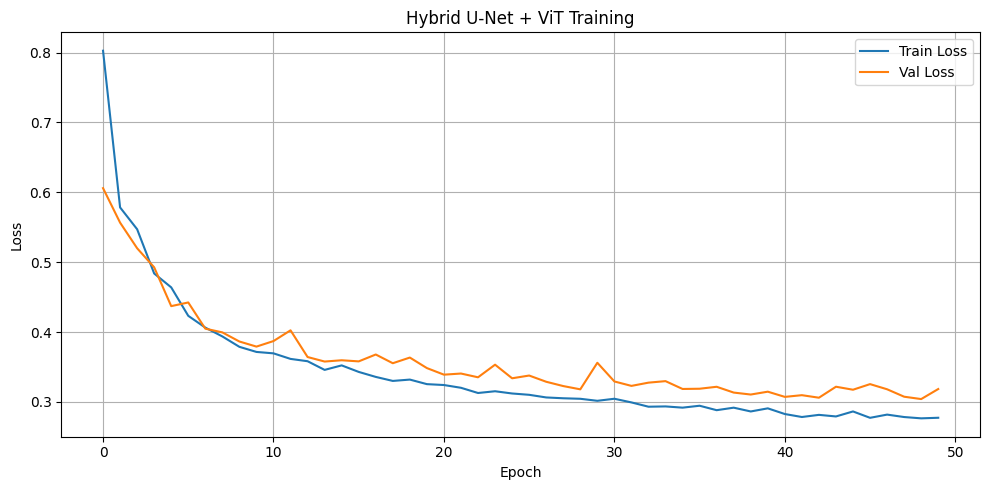

In [4]:
import os, json, random, cv2
import numpy as np
from PIL import Image
from einops import rearrange
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import segmentation_models_pytorch as smp
from timm.models.vision_transformer import VisionTransformer
import matplotlib.pyplot as plt

# Dataset & Transform
class PairedTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.transforms(image)

        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.transforms(mask)
        return image, mask

def json_to_mask(mask_json, image_size):
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    return mask

class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(root_dir, f.replace('.jpg', '.json')))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        json_path = img_path.replace('.jpg', '.json')

        image = Image.open(img_path).convert("RGB")
        with open(json_path, 'r') as f:
            mask_json = json.load(f)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return transforms.ToTensor()(image), transforms.ToTensor()(mask)


# ---- Encoder block ----
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.double_conv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = self.double_conv(512, 512)

    def double_conv(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool1(x1))
        x3 = self.conv3(self.pool2(x2))
        x4 = self.conv4(self.pool3(x3))
        x5 = self.conv5(self.pool4(x4))
        return x1, x2, x3, x4, x5

# ---- ViT Bottleneck ----
class ViTBottleneck(nn.Module):
    def __init__(self, in_channels, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=in_channels, num_heads=heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_channels, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, in_channels)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x_flat = x.flatten(2).transpose(1, 2)  # [B, H*W, C]
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x_flat = x_flat + attn_out
        x_flat = x_flat + self.ffn(x_flat)
        return x_flat.transpose(1, 2).reshape(b, c, h, w)

# ---- Decoder Block ----
class DecoderBlock(nn.Module):
    def __init__(self, x_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(x_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


# ---- Hybrid UNet + ViT ----
class HybridUNetViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.vit = ViTBottleneck(in_channels=512)
        # Correct decoder instantiations
        self.dec4 = DecoderBlock(x_channels=512, skip_channels=512, out_channels=256)
        self.dec3 = DecoderBlock(x_channels=256, skip_channels=256, out_channels=128)
        self.dec2 = DecoderBlock(x_channels=128, skip_channels=128, out_channels=64)
        self.dec1 = DecoderBlock(x_channels=64,  skip_channels=64,  out_channels=32)
        self.out_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.encoder(x)
        x5 = self.vit(x5)
        d4 = self.dec4(x5, x4)
        d3 = self.dec3(d4, x3)
        d2 = self.dec2(d3, x2)
        d1 = self.dec1(d2, x1)
        return self.out_conv(d1)


class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # Convert logits to probs
        preds = preds.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice


# --- Train ---
def train_model(model, train_loader, val_loader, device, epochs=25):
    model.to(device)
    bce_loss = nn.BCEWithLogitsLoss()
    dice_loss = DiceLoss()
    def criterion(pred, target):
        return bce_loss(pred, target) + dice_loss(pred, target)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Hybrid U-Net + ViT Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model

# --- Run Everything ---
if __name__ == "__main__":
    root_dir = "/home/adityab/ADRL/final/Data"  # Replace with your path
    dataset = CrackDataset(root_dir, transform=PairedTransform())

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = HybridUNetViT()
    trained_model = train_model(model, train_loader, val_loader, device, epochs=50)


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.transforms.functional as TF

def evaluate_metrics(model, dataloader, device, threshold=0.5, num_vis=5):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    fig, axes = plt.subplots(num_vis, 3, figsize=(10, 3 * num_vis))

    with torch.no_grad():
        count = 0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

            # --- Visualization ---
            if count < num_vis:
                for i in range(min(num_vis - count, images.size(0))):
                    img = TF.to_pil_image(images[i].cpu())
                    gt_mask = masks[i][0].cpu().numpy()
                    pred_mask = preds[i][0].cpu().numpy()

                    axes[count, 0].imshow(img)
                    axes[count, 0].set_title("Input")
                    axes[count, 1].imshow(gt_mask, cmap='gray')
                    axes[count, 1].set_title("Ground Truth")
                    axes[count, 2].imshow(pred_mask, cmap='gray')
                    axes[count, 2].set_title("Prediction")
                    for ax in axes[count]: ax.axis('off')
                    count += 1

    plt.tight_layout()
    plt.show()

    # --- Metrics ---
    y_true = np.concatenate(all_targets).flatten()
    y_pred = np.concatenate(all_preds).flatten()

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    dice = (2 * intersection) / (y_true.sum() + y_pred.sum())
    iou = intersection / union

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision:     {precision:.4f}")
    print(f"Recall:        {recall:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"Mean Dice:     {dice:.4f}")
    print(f"Mean IoU:      {iou:.4f}")


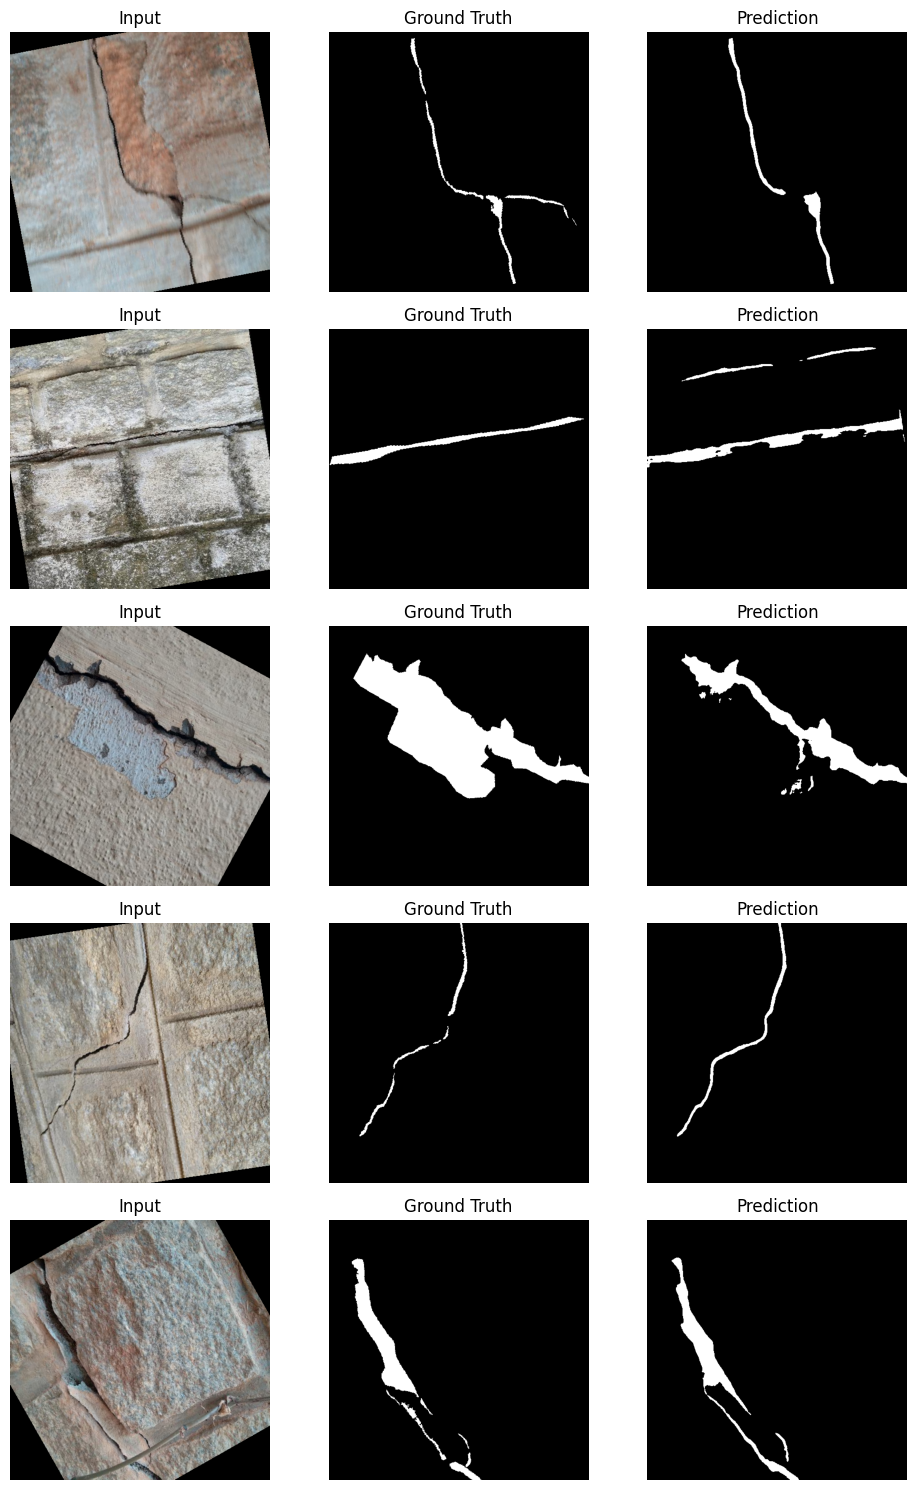


--- Evaluation Metrics ---
Precision:     0.7515
Recall:        0.7049
F1 Score:      0.7274
Mean Dice:     0.7274
Mean IoU:      0.5716


In [6]:
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)
evaluate_metrics(trained_model, test_loader, device)
